In [1]:
import cv2
import numpy as np
import math
import imutils
from matplotlib import pyplot as plt
from ponyslayer.utils import imshow, imshows, imdraw, imdraws, imdraws_color, immask, immasks, implot
from ponyslayer import unicorn, transform

## Parameters Setup

In [2]:
image_resolution = 800 # [pixel] Image ratio can be only 1:1
image_size = 400 # [mm.]
marker_size = 60 # [mm.]
marker_size_error = 0.1 # [ratio] Allowable card size error
min_path_length = 30 # [mm.]
max_path_length = 999 # [mm.]
min_path_width = 5 # [mm.]
max_path_width = marker_size + (marker_size*marker_size_error) # [mm.]
gradient_crop_ratio = 0.9 # Exclude both end (prevent too width range from noise)
min_height = 10
max_height = 20
min_intensity_range = 15 # ช่วงของ intensity ที่แคบที่สุดที่ยังถือว่าเป็น gradient

# Filter Setup

In [3]:
UnsharpMaskBeforeFindMarker = True
BlurKernelSize = (5, 5)

## Load Image

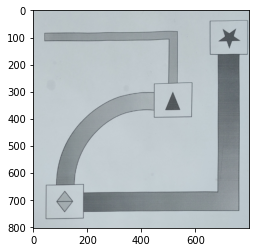

In [4]:
# frame = cv2.imread("Picture1.png")
frame = cv2.imread("Picture3.jpg")
frame = imutils.resize(frame, height=image_resolution, width = image_resolution)
original = frame.copy()
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
imshow(frame)

## Unsharp Masking

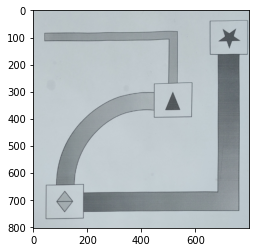

In [5]:
if UnsharpMaskBeforeFindMarker:
    blur = cv2.GaussianBlur(frame, BlurKernelSize, 0)
    frame = cv2.addWeighted(frame, 2, frame, -1, 0, frame) # Apply Unsharp Masking
    imshow(frame)
    cv2.imwrite("unsharp.jpg", frame)
    
# hist,bins = np.histogram(frame.flatten(),256,[0,256])
# cdf = hist.cumsum()
# cdf_normalized = cdf * hist.max()/ cdf.max()
# plt.plot(cdf_normalized, color = 'b')
# plt.hist(frame.flatten(),256,[0,256], color = 'r')
# plt.xlim([0,256])
# plt.legend(('cdf','histogram'), loc = 'upper left')
# plt.show()
# imshow(cv2.equalizeHist(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)))

## Enhance Marker Border

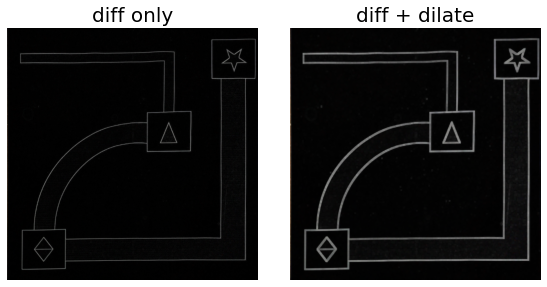

In [6]:
kernel = np.ones(BlurKernelSize,np.uint8)
# Find Marker borer by difference
dilation = cv2.dilate(frame,kernel,iterations = 1)
diff = cv2.absdiff(dilation, frame)
# Enhance Marker border thickness
diff_dilated = cv2.dilate(diff,kernel,iterations = 1)

imshows([diff, diff_dilated], ['diff only', 'diff + dilate'])

# Select image with filtered border
frame = diff_dilated

## Find Marker

Match 91.74%
Match 92.47%
Match 92.45%


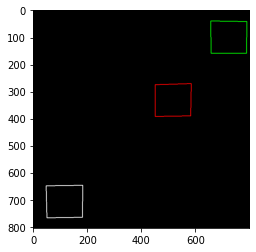

In [7]:
edges = cv2.Canny(frame, 20, 100)

contours,hierarchy = cv2.findContours(edges, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) # RETR_EXTERNAL
hierarchy = hierarchy[0] # get the actual inner list of hierarchy descriptions

cp = unicorn.ContourProcessor()
cp.set_param(image_resolution, image_size, marker_size, marker_size_error, min_path_length, max_path_length, min_path_width, max_path_width)

cnts_marker = cp.get_marker_contours(contours)
imdraws_color(cnts_marker, frame, mode = 1, size = 2)

Markers = [unicorn.Marker(c) for c in cnts_marker]

## Remove Marker from image

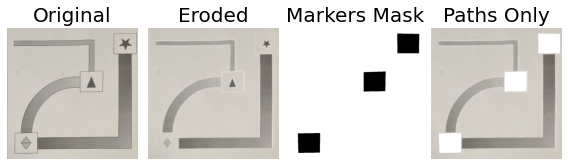

In [8]:
marker_mask = immasks(cnts_marker, frame, show = False)

## Erode image before masking to get rid of marker border
original_eroded = cv2.dilate(original.copy(),kernel,iterations = 2)

## Remove marker and fill with white
path_img = cv2.bitwise_and(original_eroded, original_eroded, mask=marker_mask)
path_img = cv2.fillPoly(path_img, cnts_marker, (255, 255, 255))
imshows([original, original_eroded, marker_mask, path_img], ['Original', 'Eroded', 'Markers Mask', 'Paths Only'])

## Find Contour of Paths

Found 554 path.
Found 3 filtered path.


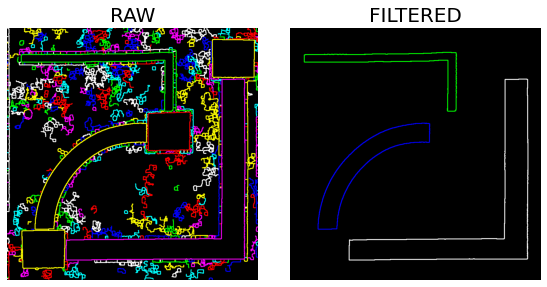

In [9]:
edges = cv2.Canny(path_img, 20, 100, apertureSize = 5, L2gradient = True) # ถ้า apertureSize มากไปจะไม่เห็น path ที่แคบ
# apertureSize: aperture size for the Sobel operator [Select from (3, 5, 7)]
# L2gradient: True = Euclidean Distance (More acculate), False = Manhattan Distance
cnts_path, hierarchy_path = cv2.findContours(edges,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) # ไม่ต้อง APPROX เพราะว่าจะเอามาหา path ต่อ
print("Found {} path.".format(len(cnts_path)))
canvas_path_raw = imdraws_color(cnts_path, frame, mode=1, size = 2, show = False)
# Filter Path
cnts_path_filtered = cp.get_path_contours(cnts_path, Markers, frame)
print("Found {} filtered path.".format(len(cnts_path_filtered)))
canvas_path_filtered = imdraws_color(cnts_path_filtered, frame, mode=1, size = 2, show = False)
imshows([canvas_path_raw, canvas_path_filtered], ['RAW', 'FILTERED'])
Paths = [unicorn.Path(c) for c in cnts_path_filtered]

## Locate First Marker

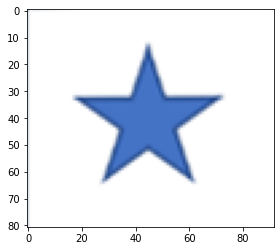

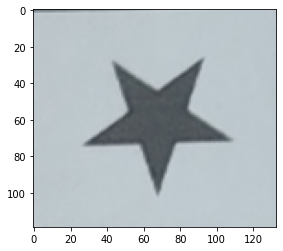

In [10]:
first_marker_src = cv2.imread("Start1.png")
imshow(first_marker_src)

###########################################

first_marker = Markers[2]
# imshow(transform.four_point_transform(original, cp.getPointArray(first_marker.contour)))
imshow(first_marker.getImage(original))

## Sort Marker & Path

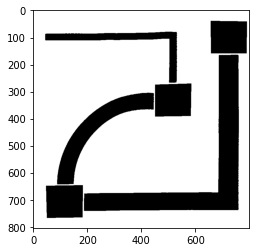

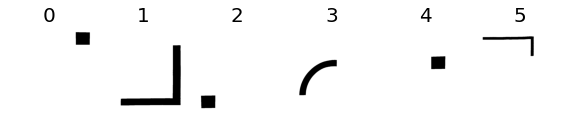

In [11]:
### Sort Marker & Path ###
present = first_marker
sorted_object = []
sorted_object.append(present)
n_object = len(Markers) + len(Paths)
while n_object != len(sorted_object):
    candidates = list(filter(lambda x: x not in sorted_object, Markers + Paths)) # Unsorted objects
    _isPath_next = present in Markers # Marker -> Path -> Marker -> Path -> Marker -> Path
    present = sorted(candidates, key=lambda o: cp.minDistance(present.contour, o.contour))[0]
    sorted_object.append(present)
immasks([x.contour for x in sorted_object], frame)
visual = [immask(item.contour, frame) for item in sorted_object]
imshows(visual, [str(x) for x in range(len(visual))])

## Assign Start point on each Path

(729, 165)
(115, 642)
(516, 267)


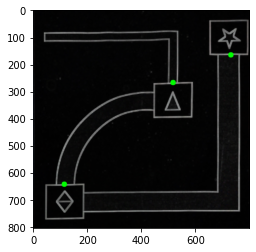

In [12]:
canvas = frame.copy()
for i in range(int(len(sorted_object)/2)):
    marker = sorted_object[2*i]
    path = sorted_object[2*i+1]
    path_start_point = cp.nearestPoint(marker.center, path.contour)
    path.set_start(path_start_point)
    print(path.start)
    cv2.circle(canvas, path.start, 10, (0, 255, 0), -1)
imshow(canvas)

## Generate 2D Waypoints and Extract Gradient

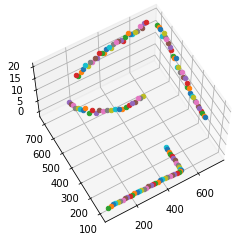

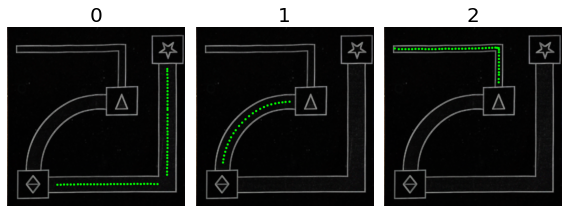

In [13]:
# Visualize
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
visual = []
for Path in Paths:
    duo_list, middle = Path.generate_trajectory2D_rev3(Markers, cp.marker_size_pixel, marker_size_error*2, step_size = 15)
    canvas = frame.copy()
    for i in range(len(middle)): cv2.circle(canvas, middle[i], 5, (0, 255, 0), -1)
    visual.append(canvas)
    waypoints3D = Path.generate_trajectory3D(src=gray,
                                             min_height=min_height,
                                             max_height=max_height,
                                             gradient_crop_ratio=gradient_crop_ratio,
                                             min_intensity_range=min_intensity_range)
    
    
    for waypoint in waypoints3D: ax.scatter(waypoint[0], waypoint[1], waypoint[2])
ax.view_init(azim=-120, elev=60)
plt.show()
imshows(visual, [str(i) for i in range(len(visual))])

## Generate 3D Waypoints

<IPython.core.display.Javascript object>


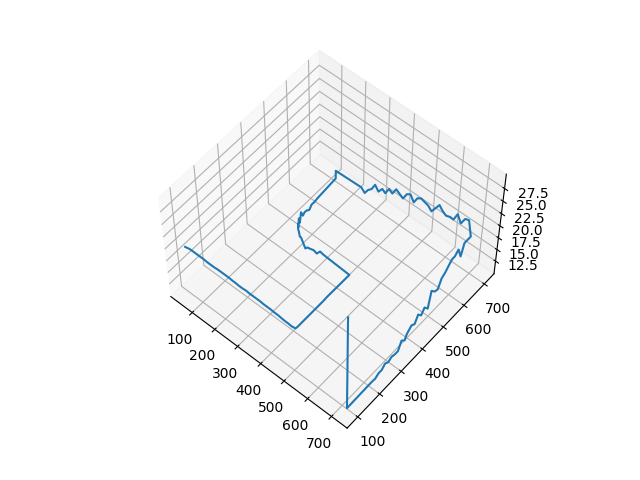

In [14]:
H = 30 # Height buffer
waypoints = [] # List of (x, y, z)
for i in range(len(Markers)):
    ### Marker ###
    (x, y) = sorted_object[2*i].center
    waypoints.append((x, y, H)) # Hold height
    if Paths[i].waypoints3D[0][2] == -1: z = H
    else: z = Paths[i].waypoints3D[0][2]
    waypoints.append((x, y, z)) # Adjust height
    H = z # update history
    ### Path ###
    for (x, y, z) in Paths[i].waypoints3D:
#         print(H)
        if z == -1: z = H # Hold height
        waypoints.append((x, y, z))
        H = z # update history
%matplotlib notebook
fig = plt.figure()
ax = fig.gca(projection='3d')
# for waypoint in waypoints: ax.scatter(waypoint[0], waypoint[1], waypoint[2])
x = [waypoints[i][0] for i in range(len(waypoints))]
y = [waypoints[i][1] for i in range(len(waypoints))]
z = [waypoints[i][2] for i in range(len(waypoints))]
ax.plot(x, y, z)
plt.show()